# DSCI 100 Project: Predicting Newsletter Subscription with KNN Classification

***NOTE:** The models in this notebook are quite computationally expensive to tune; running this notebook on the DSCI 100 Jupyter Hub server has been tested to work but will take ~15mins. This notebook was created with a local kernel and parallel processing.*

In [3]:
# Uncomment for parallel processing (Uses all cores except 1):
# num_cores <- detectCores() - 1
# cl <- makeCluster(num_cores)
# registerDoParallel(cl)

In [2]:
library(tidyverse)
library(tidymodels)
library(scales)
library(themis)
library(cowplot)
library(doParallel) # parallel processing
options(repr.matrix.max.rows = 6)

set.seed(1000)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.3.0 ──

✔ broom        1.0.7     ✔ rsample      1.2.1
✔ dials        1.4.0     ✔ tune         1.3.0
✔ infer        1.0.7     ✔ workflows    1.2.0
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.3.0     ✔ yardstick    1.3.2
✔ recipes      1.1.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## (1) Introduction

The Pacific Laboratory for Artificial Intelligence (PLAI), to advance embodied AI research, has set up a Minecraft server named PLAICRAFT to collect behavioural data on volunteer players. A portion of the data from PLAI's endeavours has been provided for this project: the `players.csv` data set. The details of `players.csv` are summarized below. See section 2.3.1 for the calculation of summary values reported here:

### (1.1) `players.csv`
This dataset contains the following 7 variables regarding 196 players from the server: 
|**Variable**|**Read Data Type**|**Proper Data Type**|**Description**|
|:-:|:-:|:-:|:-|
|experience|`chr`|`fct`|Self-evaluated Minecraft experience level. One of: *Beginner*, *Amateur*, *Regular*, *Pro* or *Veteran*.|
|subscribe|`lgl`|`fct`|Whether player is subscribed to a game-related newsletter. 144 are subscribed, 52 are not.|
|hashedEmail|`chr`|`chr`|Encrypted email.|
|played_hours|`dbl`|`dbl`|Hours played on the server. Mean = 5.8h, min = 0h, max = 223.1.|
|name|`chr`|`chr`|Player's auto-generated genric name.|
|gender|`chr`|`fct`| One of: *Male*, *Female*, *Non-binary*, *Agender*, *Two-spirited*, *Other* or *Perfer not to say*.|
|Age|`dbl`|`int`|Self-reported age. Players must be at least 7. The age selector had a maximum age of 99 and a default of 17. Mean = 20.5, min = 8, max = 50.|

**Potential issues:** 
- `subscribe` will need balancing for KNN classification.
- There are an inordinate number of 17-year-olds (see section 3.7) due to 17 being the default age on the given survey.
- The small sample size increases the effects of random unaccountable fluctuations in data.

### (1.2) Research Question
***Can the self-reported age, self-reported experience level, and the total hours played by a given player predict whether that player will be subscribed to receive a game-related newsletter, as determined with players in the PLAICRAFT Minecraft server?***

The `players.csv` dataset will be used. The `Age`, `experience`, `played_hours` and `subscribe` variables will be isolated. `Age`, `experience` and `played_hours` will then be selected via best-subset-selection and KNN classification to predict `subscribe`.

### (1.3) Thesis
Using all of the self-reported age, self-reported experience level, and the total hours played by a given player on the PLAICRAFT Minecraft server is the subset of predictors that yields the highest accuracy. This accuracy is **61.2%**, which is better than random guessing, but due to being lower than the proportion of the majority label (73.1%), it is not sufficient to render the model useful for prediction.

## (2) Methods & Results

### (2.1) Data Reading
Data will be read remotely from GitHub and stored in a tibble in `players`:

In [4]:
players_url <- "https://raw.githubusercontent.com/mke-l/dsci100-project-data/refs/heads/main/data/players.csv"
players_raw <- read_csv(players_url)

players_raw

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


### (2.2) Data Cleaning and Wrangling
**(2.2.1)** Conversion of `players`' variables to proper data type, tidying of variable names, reordering of experience factor:

In [5]:
players_clean <- players_raw |>
    mutate(experience = as_factor(experience)) |>
    mutate(subscribe = as_factor(subscribe)) |>
    rename(hashed_email = hashedEmail) |>
    mutate(gender = as_factor(gender)) |>
    rename(age = Age) |>
    mutate(age = as.integer(age)) |>
    mutate(experience = fct_relevel(experience, "Beginner", "Amateur", "Regular", "Pro", "Veteran"))

players_clean

experience,subscribe,hashed_email,played_hours,name,gender,age
<fct>,<fct>,<chr>,<dbl>,<chr>,<fct>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


**(2.2.2)** Isolation of relevant variables: `experience`, `subscribe`, `played_hours` and `age`:

In [6]:
players_wrangled <- players_clean |>
    select(experience, subscribe, played_hours, age)

players_wrangled

experience,subscribe,played_hours,age
<fct>,<fct>,<dbl>,<int>
Pro,TRUE,30.3,9
Veteran,TRUE,3.8,17
Veteran,FALSE,0.0,17
⋮,⋮,⋮,⋮
Amateur,FALSE,0.0,17
Amateur,FALSE,2.3,17
Pro,TRUE,0.2,NA


### (2.3) Exploratory Numerical Data Analysis
**(2.3.1)** Computing mean, min and max values for all `players_wrangled` quantative variables:

In [7]:
players_stats <- players_wrangled |>
    select(played_hours, age) |>
    summarize(mean_played_hours = mean(played_hours),
              min_played_hours = min(played_hours),
              max_played_hours = max(played_hours),
              mean_age = mean(age, na.rm = TRUE),
              min_age = min(age, na.rm = TRUE),
              max_age = max(age, na.rm = TRUE))

players_stats

mean_played_hours,min_played_hours,max_played_hours,mean_age,min_age,max_age
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
5.845918,0,223.1,20.52062,8,50


It is noted that the average played hours of players on the PLAICRAFT server is 5.8 hours with a range of 0-223.1 hours. The average age of players on the PLAICRAFT server is 20.5 with a range of 8-50 years old.

**(2.3.2)** Distribution of players subscribed and not subscribed to the newsletter:

In [8]:
players_wrangled |>
    group_by(subscribed_to_newsletter = subscribe) |>
    summarize(count = n())

subscribed_to_newsletter,count
<fct>,<int>
FALSE,52
TRUE,144


This shows an considerable imbalence in the label, this will need to be balenced during later analysis.

### (2.4) Exploratory Visual Data Analysis

**(2.4.1)** Distribution of players by age:

Warning message:
"Removed 2 rows containing non-finite outside the scale range (`stat_count()`)."


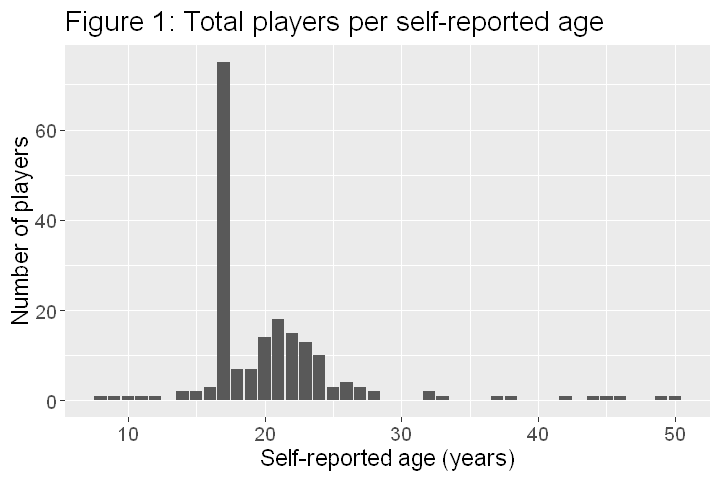

In [9]:
options(repr.plot.width = 6, repr.plot.height = 4)

ggplot(players_wrangled, aes(x = age)) +
    geom_bar(stat = "count") +
    labs(title = "Figure 1: Total players per self-reported age",
        x = "Self-reported age (years)",
        y = "Number of players") +
    theme(text = element_text(size = 14))

This shows that the general non-outlying data is symmetric around a mode of 21 years, with a longer tail towards higher ages since players must be at least 7 but can be up to 99. There is also an extreme spike at 17 years old due to 17 being the default age on the data collection survey (Pacific Laboratory of Artificial Intelligence, 2024).

**(2.4.2)** Fraction of players subscribed to the newsletter per experience level:

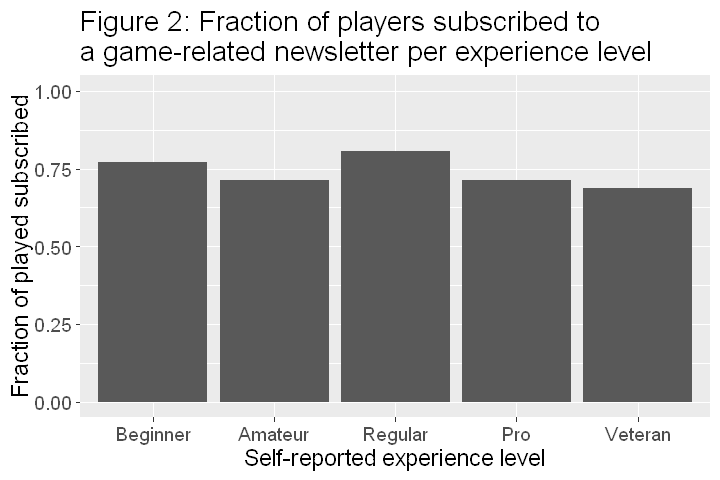

In [10]:
players_experience_count <- players_wrangled |>
    group_by(experience) |>
    summarize(total = n())

players_subscribed_experiance_count <- players_wrangled |>
    filter(subscribe == TRUE) |>
    group_by(experience) |>
    summarize(subscribed = n())

players_experience_subscribed_fraction <- players_experience_count |>
    bind_cols(subscribed = pull(players_subscribed_experiance_count, subscribed)) |>
    mutate(fraction = subscribed/total)


ggplot(players_experience_subscribed_fraction, aes(x = experience, y = fraction)) +
    geom_bar(stat = "identity") +
    ylim(c(0, 1)) +
    labs(title = "Figure 2: Fraction of players subscribed to \na game-related newsletter per experience level",
        x = "Self-reported experience level",
        y = "Fraction of played subscribed") +
    theme(text = element_text(size = 14))

There is a general downwards trend in subscriptions as experience increases with the exception of players of *Regular* experience. This shows experience may be a useful predictor of subscription.

**(2.4.3)** Total play time and age of each player colored according to subscription status:

Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


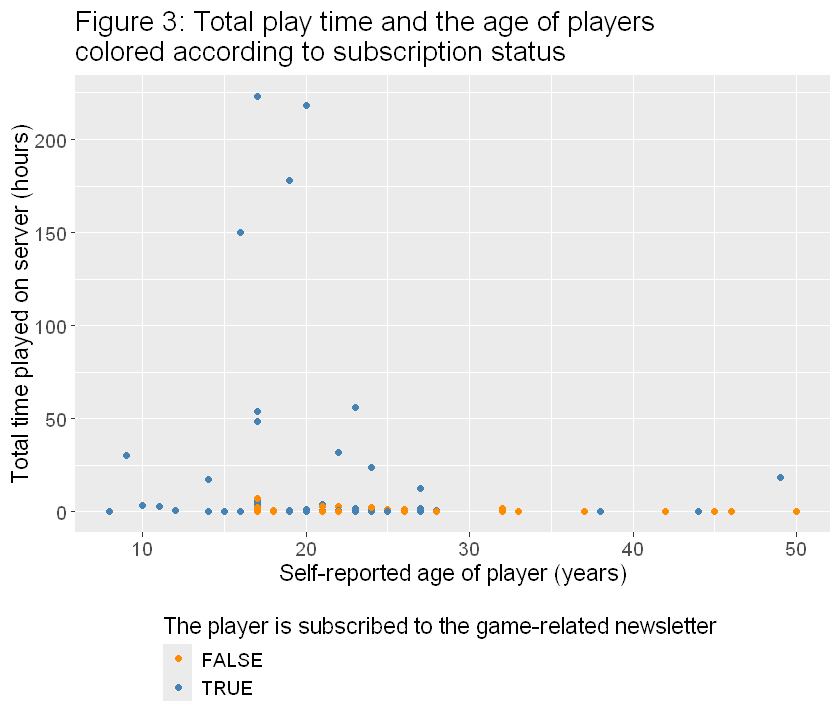

In [11]:
options(repr.plot.width = 7, repr.plot.height = 6)

players_time_vs_age <- ggplot(players_wrangled, aes(x = age, y = played_hours, color = subscribe)) +
    geom_point() +
    labs(title = "Figure 3: Total play time and the age of players \ncolored according to subscription status",
        x = "Self-reported age of player (years)",
        y = "Total time played on server (hours)",
        color = "The player is subscribed to the game-related newsletter") +
    scale_color_manual(values = c("darkorange", "steelblue")) +
    theme(text = element_text(size = 14),
         legend.position = "bottom",
         legend.direction = "vertical")

players_time_vs_age

Most players appear to have very low play time, except a few players with very high play time in the hundreds of hours. The below logarithmic time played scale shows a more detailed view of players:

Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


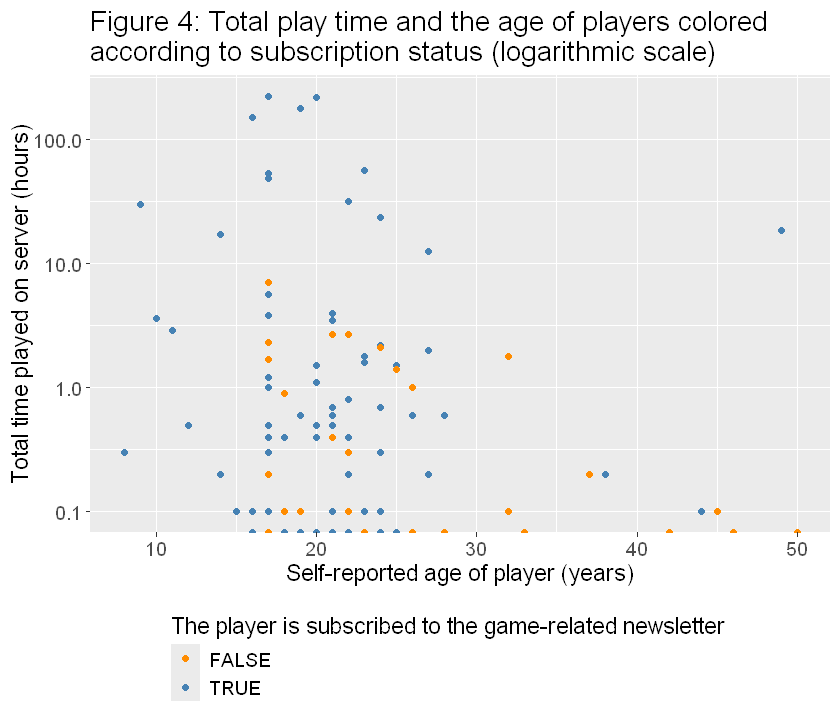

In [12]:
players_time_vs_age_log10 <- players_time_vs_age + 
    scale_y_log10() +
    ggtitle("Figure 4: Total play time and the age of players colored \naccording to subscription status (logarithmic scale)")

players_time_vs_age_log10

It is seen generally that players of higher playtime and lesser age are more likely to be subscribed to a game-related newsletter. Though the relationship is highly mixed, these two variables could both prove useful in predicting subscription.

### (2.5) Data Analysis

**(2.5.01)** Plan of analysis:

The experience levels *Beginner*, *Amateur*, *Regular*, *Pro* and *Veteran* will be recoded as integers 1-5, respectively. Observations with NAs will be dropped. The data will be split into 75% training and 25% testing data, and balanced over the `subscribe` variable. With the training data, best subset selection will determine which of `age`, `experience` and `played_hours` will be included in a KNN classification model to predict `subscribe`. 10-fold cross-validation will determine the optimal value for K. Finally, the resulting prediction model will be assessed with the test data.

The label is a boolean variable, making it suitable for classification. Best subset selection and cross-validation will ensure optimization of KNN classification. It is assumed that the bias in the age predictor for 17 will not have too great an effect on predictions. Although no predictor correlated strongly with the label, they are the best available choices.

**(2.5.02)** Mapping experience levels *Beginner*, *Amateur*, *Regular*, *Pro* and *Veteran* to integers 1-5:

In [13]:
players_integers <- players_wrangled |>
    mutate(experience = as.integer(experience))

players_integers

experience,subscribe,played_hours,age
<int>,<fct>,<dbl>,<int>
4,TRUE,30.3,9
5,TRUE,3.8,17
5,FALSE,0.0,17
⋮,⋮,⋮,⋮
2,FALSE,0.0,17
2,FALSE,2.3,17
4,TRUE,0.2,NA


**(2.5.03)** Dropping NAs (Since there's only two observations with NAs, this operation is applicable):

In [14]:
players <- players_integers |>
    drop_na()

players

experience,subscribe,played_hours,age
<int>,<fct>,<dbl>,<int>
4,TRUE,30.3,9
5,TRUE,3.8,17
5,FALSE,0.0,17
⋮,⋮,⋮,⋮
5,FALSE,0.3,22
2,FALSE,0.0,17
2,FALSE,2.3,17


**(2.5.04)** Creating the initial split with stratification over `subscribe`:

In [15]:
set.seed(1000)

players_split <- players |>
    initial_split(prop = 0.75, strata = subscribe)

players_training <- training(players_split)
players_testing <- testing(players_split)

players_training

experience,subscribe,played_hours,age
<int>,<fct>,<dbl>,<int>
2,FALSE,0.0,22
2,FALSE,0.1,17
5,FALSE,0.1,18
⋮,⋮,⋮,⋮
2,TRUE,0,17
1,TRUE,0,17
2,TRUE,0,17


The training data will be investigated further to aid in future analysis:

In [16]:
players_training |>
    group_by(subscribe) |>
    summarize(count = n())

subscribe,count
<fct>,<int>
FALSE,39
TRUE,106


It is seen that $\frac{39}{145} \approx$ 26.8% of the training data is non-subscribers while the remaining 73.1% are subscribers.

**(2.5.05)** Creating recipies for each subset with centering, scaling and upsampling (balance):

In [17]:
set.seed(1000)

exp_recipe <- recipe(subscribe ~ experience, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1)

hrs_recipe <- recipe(subscribe ~ played_hours, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1)

age_recipe <- recipe(subscribe ~ age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1)

exp_hrs_recipe <- recipe(subscribe ~ experience + played_hours, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1)

exp_age_recipe <- recipe(subscribe ~ experience + age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1)

hrs_age_recipe <- recipe(subscribe ~ played_hours + age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1)

exp_hrs_age_recipe <- recipe(subscribe ~ ., data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1)

**(2.5.06)** Tuning model specification:

In [18]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


**(2.5.07)** 10-fold cross-validation specification:

In [19]:
set.seed(1000)

players_vfold <- vfold_cv(players_training, v = 10, strata = subscribe)

print(players_vfold)

#  10-fold cross-validation using stratification 
# A tibble: 10 × 2
   splits           id    
   <list>           <chr> 
 1 <split [130/15]> Fold01
 2 <split [130/15]> Fold02
 3 <split [130/15]> Fold03
 4 <split [130/15]> Fold04
 5 <split [130/15]> Fold05
 6 <split [130/15]> Fold06
 7 <split [131/14]> Fold07
 8 <split [131/14]> Fold08
 9 <split [131/14]> Fold09
10 <split [132/13]> Fold10


Note that when using step_upsample() with cross-validation, the training set is balanced whilst the validation set is not.

**(2.5.08)** Creating tibble of all neighbor counts to test. 1-185 neighbours will be tested as this covers all potential values for each recipe but is not too computationally expensive as the dataset is quite small. Testing the maximum range will provide the maximum insight into our data possible.

In [20]:
neighbors <- tibble(neighbors = c(1:185))

**(2.5.09)** Tuning `experience` predictor subset

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
125,accuracy,binary,0.5386813,10,0.03642602,Preprocessor1_Model125


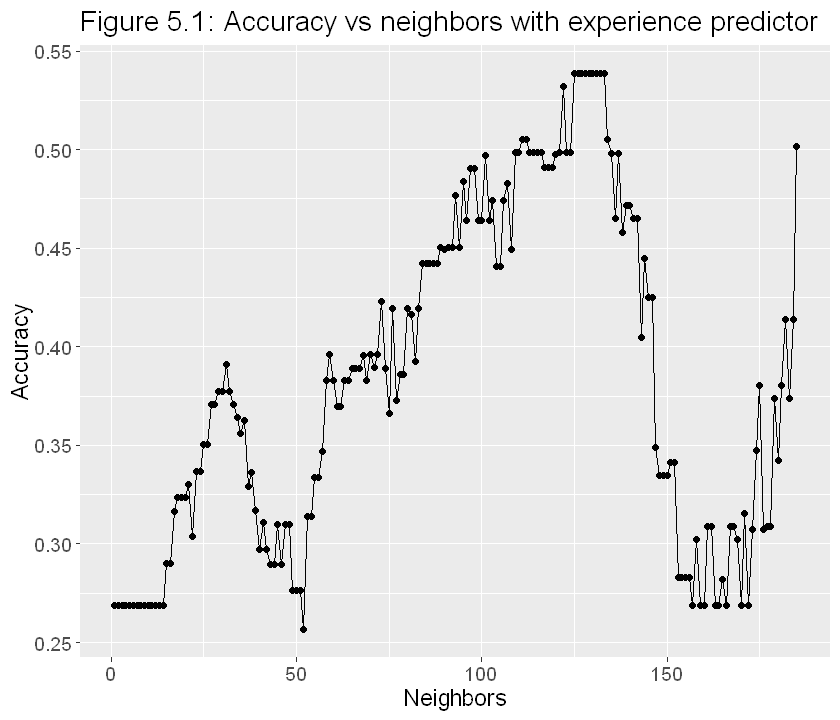

In [21]:
exp_metrics <- workflow() |>
    add_recipe(exp_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

exp_tuning_plot <- exp_metrics |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 5.1: Accuracy vs neighbors with experience predictor",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

exp_tuning_plot
slice(exp_metrics, 1)


The pattern appears to be quite erratic, another two vfolds will be created to see if the same pattern emerges again.

In [22]:
set.seed(2000)

players_vfold2 <- vfold_cv(players_training, v = 10, strata = subscribe)

In [23]:
set.seed(3000)

players_vfold3 <- vfold_cv(players_training, v = 10, strata = subscribe)

In [24]:
exp_metrics2 <- workflow() |>
    add_recipe(exp_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold2, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

exp_tuning_plot2 <- exp_metrics2 |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 5.2: Accuracy vs neighbors with experience predictor \ncomparison",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


In [25]:
exp_metrics3 <- workflow() |>
    add_recipe(exp_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold3, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

exp_tuning_plot3 <- exp_metrics3 |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 5.3: Accuracy vs neighbors with experience predictor \ncomparison",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
125,accuracy,binary,0.5386813,10,0.03642602,Preprocessor1_Model125


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
185,accuracy,binary,0.5624176,10,0.04939064,Preprocessor1_Model185


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
103,accuracy,binary,0.5627473,10,0.04506041,Preprocessor1_Model103


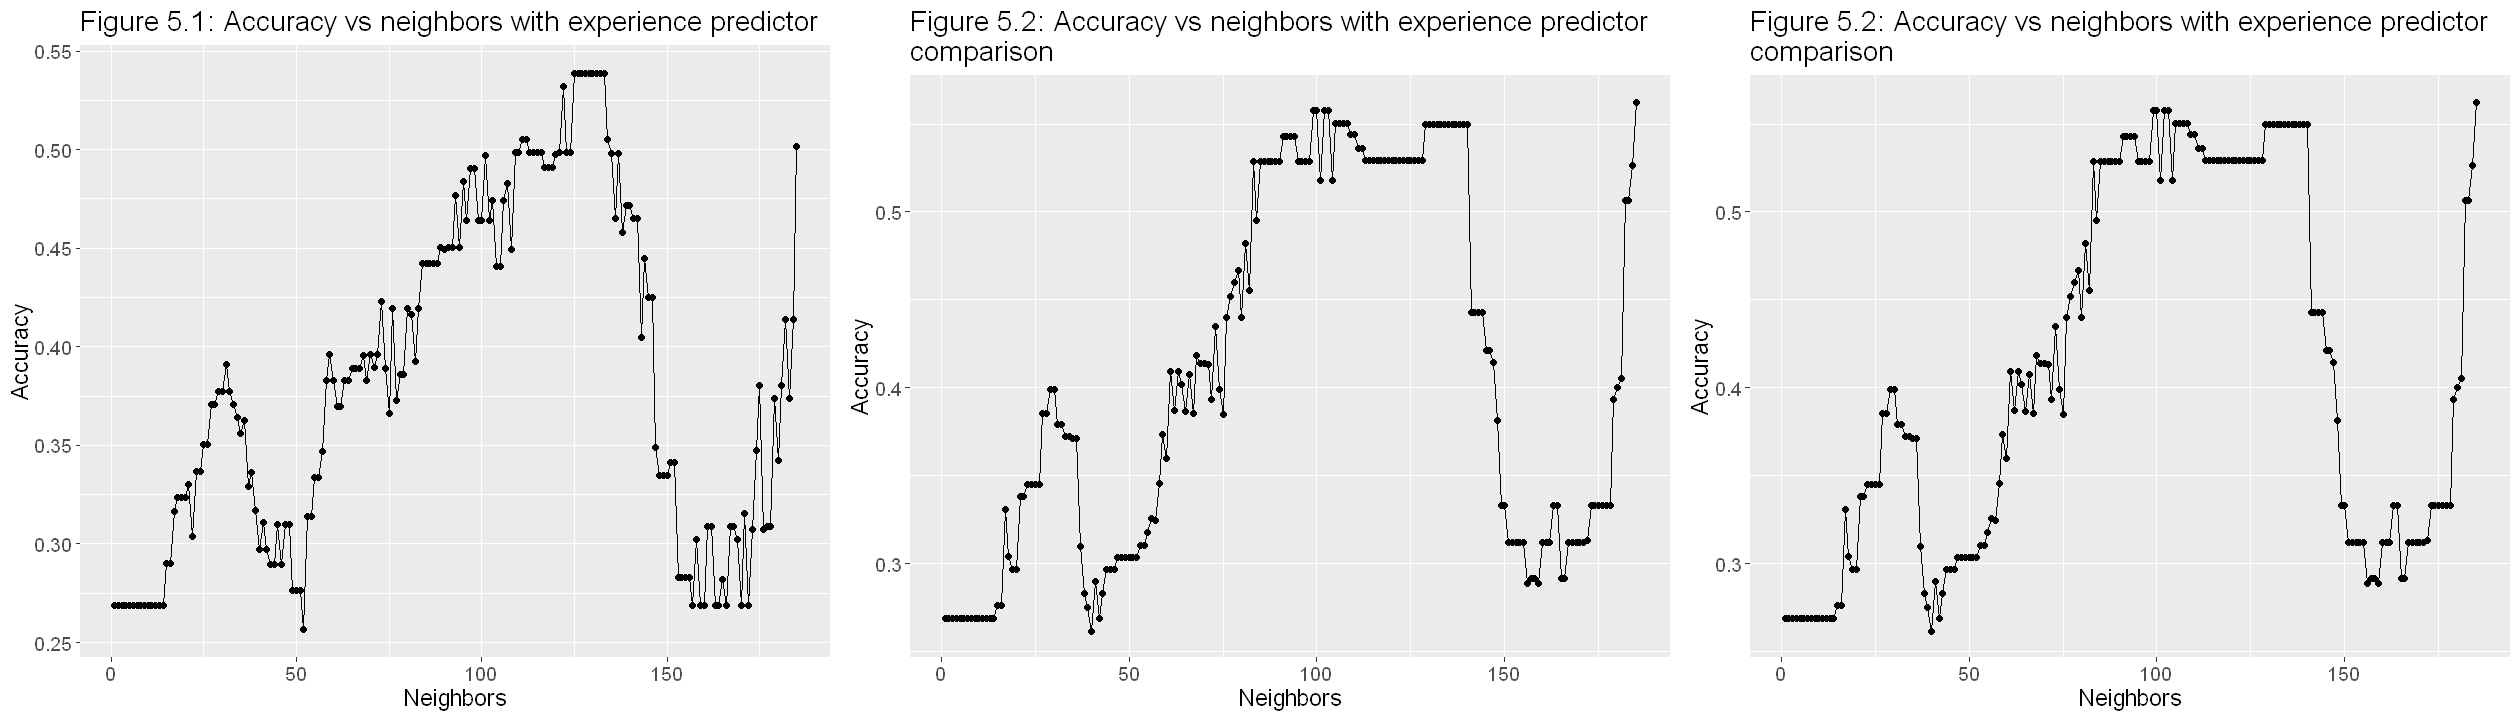

In [26]:
options(repr.plot.width = 21, repr.plot.height = 6)
plot_grid(exp_tuning_plot, exp_tuning_plot2, exp_tuning_plot2, ncol = 3)
slice(exp_metrics, 1)
slice(exp_metrics2, 1)
slice(exp_metrics3, 1)

These three cases had a peak accuracies of **53.9%-56.3%**. However, this is far worse than just guessing the majority label (73.1%).

**(2.5.10)** Tuning `played_hours` predictor subset

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
161,accuracy,binary,0.5920147,10,0.04034469,Preprocessor1_Model161


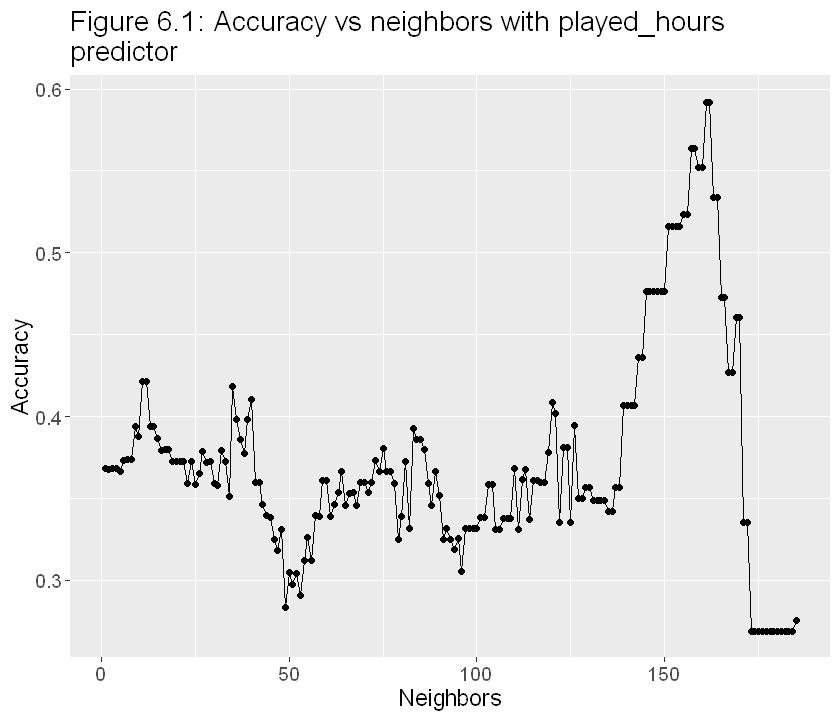

In [27]:
hrs_metrics <- workflow() |>
    add_recipe(hrs_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

options(repr.plot.width = 7, repr.plot.height = 6)

hrs_tuning_plot <- hrs_metrics |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 6.1: Accuracy vs neighbors with played_hours \npredictor",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

hrs_tuning_plot
slice(hrs_metrics, 1)

As before, this is also erratic, the other two vfolds will be used here again to view consistencies:

In [28]:
hrs_metrics2 <- workflow() |>
    add_recipe(hrs_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold2, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

hrs_tuning_plot2 <- hrs_metrics2 |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 6.2: Accuracy vs neighbors with played_hours \npredictor comparison",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


In [29]:
hrs_metrics3 <- workflow() |>
    add_recipe(hrs_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold3, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

hrs_tuning_plot3 <- hrs_metrics3 |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 6.3: Accuracy vs neighbors with played_hours \npredictor comparison",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
161,accuracy,binary,0.5920147,10,0.04034469,Preprocessor1_Model161


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
155,accuracy,binary,0.5863736,10,0.05570926,Preprocessor1_Model155


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
149,accuracy,binary,0.6031136,10,0.04966937,Preprocessor1_Model149


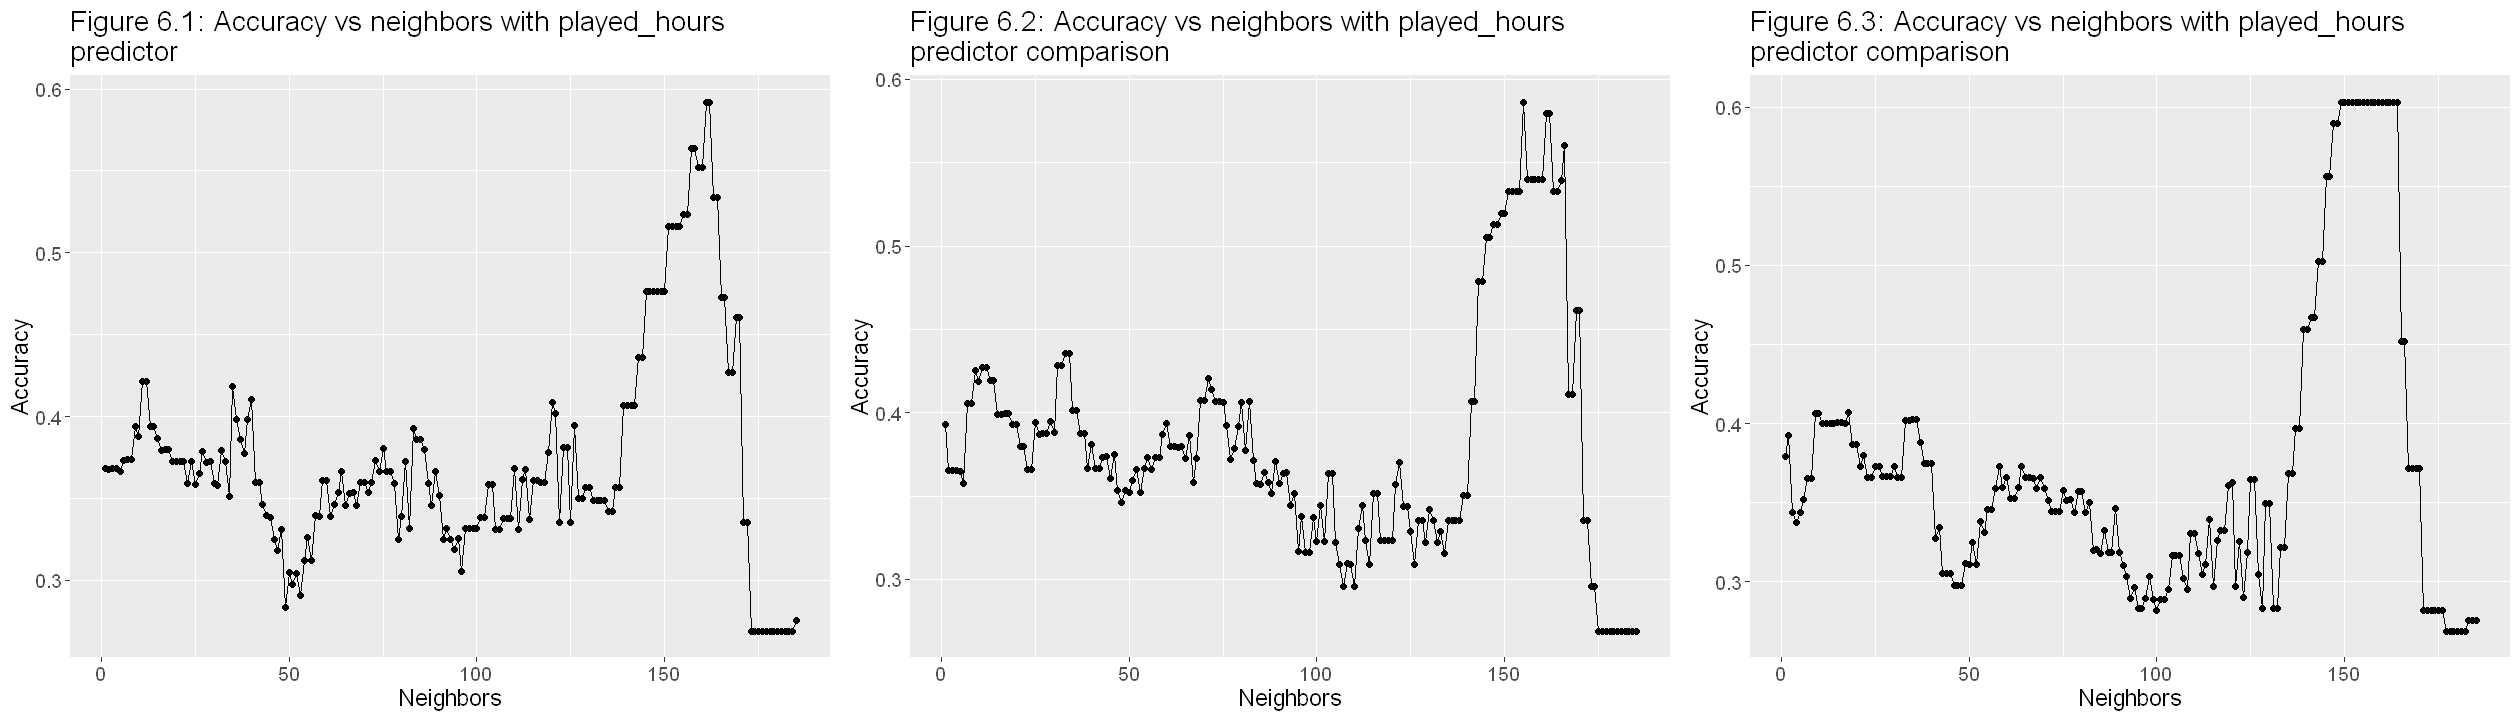

In [30]:
options(repr.plot.width = 21, repr.plot.height = 6)
plot_grid(hrs_tuning_plot, hrs_tuning_plot2, hrs_tuning_plot3, ncol = 3)
slice(hrs_metrics, 1)
slice(hrs_metrics2, 1)
slice(hrs_metrics3, 1)

`played_hours` performed better than `experience` with accuracies ranging from **58.6%-60.3%**. This is still far below just guessing the majority label but is an improvment.

**(2.5.11)** Tuning `age` predictor subset

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
179,accuracy,binary,0.6235531,10,0.05591397,Preprocessor1_Model179


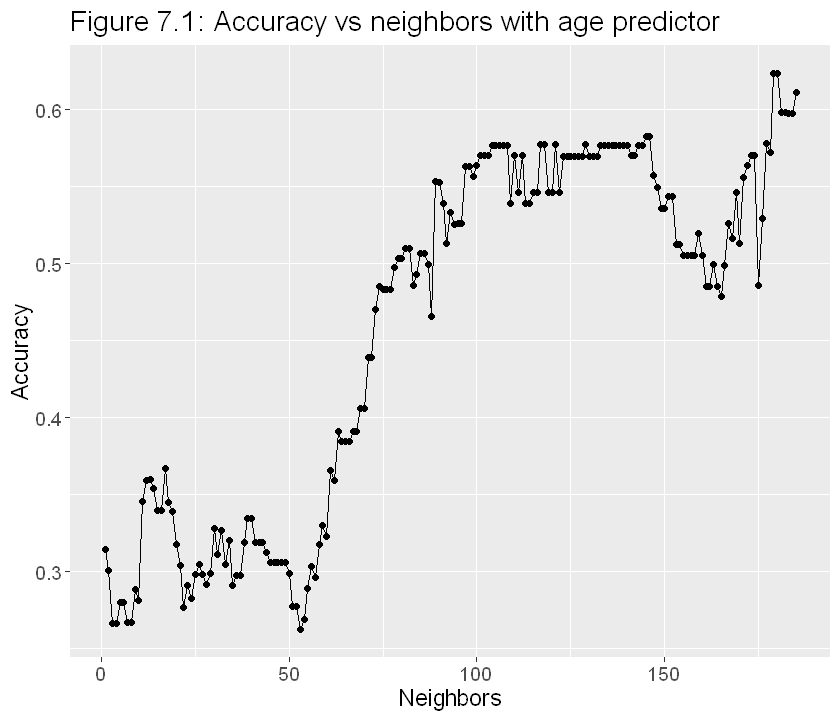

In [31]:
age_metrics <- workflow() |>
    add_recipe(age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

options(repr.plot.width = 7, repr.plot.height = 6)

age_tuning_plot <- age_metrics |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 7.1: Accuracy vs neighbors with age predictor",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

age_tuning_plot
slice(age_metrics, 1)

Again, the two additional vfolds will be tested:

In [32]:
age_metrics2 <- workflow() |>
    add_recipe(age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold2, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

age_tuning_plot2 <- age_metrics2 |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 7.2: Accuracy vs neighbors with age predictor \ncomparison",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


In [33]:
age_metrics3 <- workflow() |>
    add_recipe(age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold3, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

age_tuning_plot3 <- age_metrics3 |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 7.3: Accuracy vs neighbors with age predictor \ncomparison",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
179,accuracy,binary,0.6235531,10,0.05591397,Preprocessor1_Model179


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
181,accuracy,binary,0.6825641,10,0.04986134,Preprocessor1_Model181


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
185,accuracy,binary,0.6855678,10,0.049825,Preprocessor1_Model185


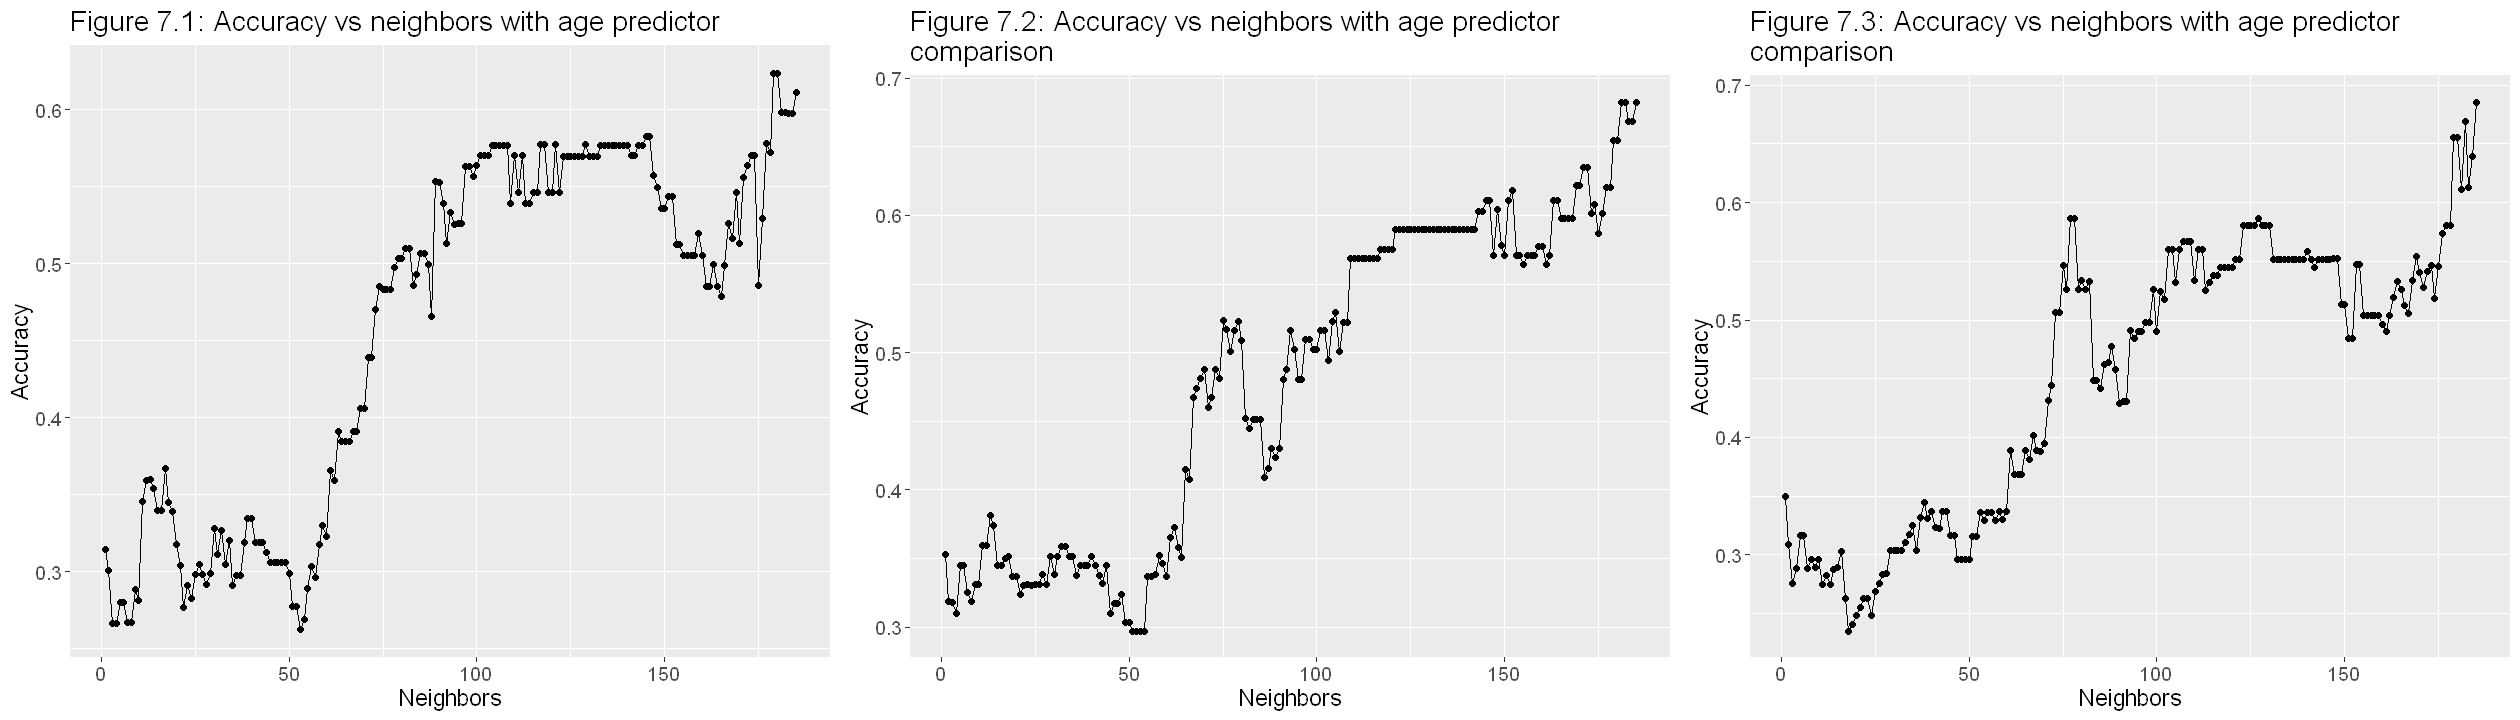

In [34]:
options(repr.plot.width = 21, repr.plot.height = 6)
plot_grid(age_tuning_plot, age_tuning_plot2, age_tuning_plot3, ncol = 3)
slice(age_metrics, 1)
slice(age_metrics2, 1)
slice(age_metrics3, 1)

The `age` predictor yielded an accuracy range of **62.4%-68.5%**. This is yet another improvment but it must be noted that these accuracies occur only when nearly all neighbors are considered, this is reflective of simply guessing the majority label and argues that no real useful predictions are being made.

**(2.5.12)** Tuning `experience` and `played_hours` predictor subset

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
38,accuracy,binary,0.5601832,10,0.04131137,Preprocessor1_Model038


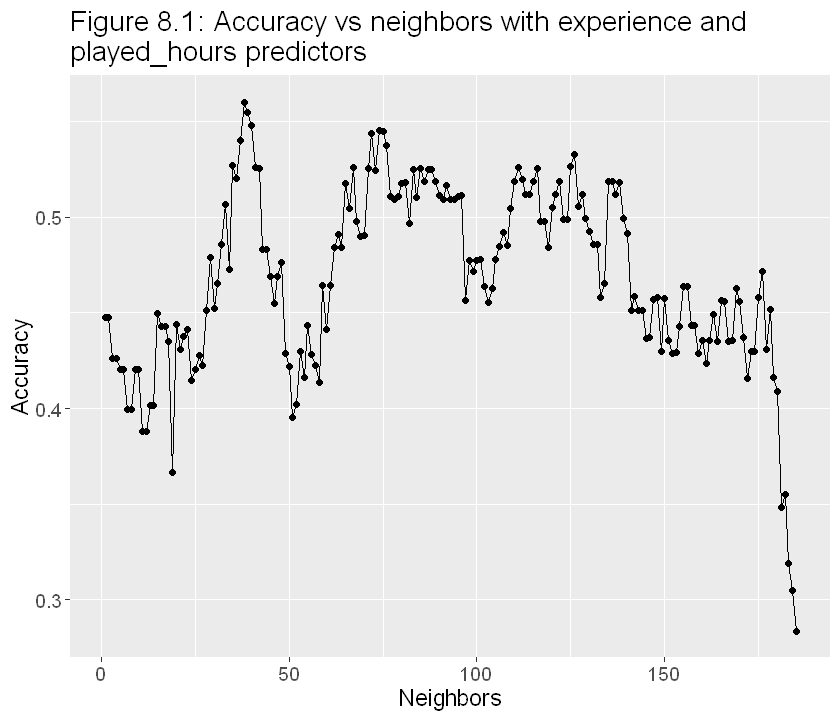

In [35]:
exp_hrs_metrics <- workflow() |>
    add_recipe(exp_hrs_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

options(repr.plot.width = 7, repr.plot.height = 6)

exp_hrs_tuning_plot <- exp_hrs_metrics |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 8.1: Accuracy vs neighbors with experience and \nplayed_hours predictors",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

exp_hrs_tuning_plot
slice(exp_hrs_metrics, 1)

Two addition vfolds:

In [36]:
exp_hrs_metrics2 <- workflow() |>
    add_recipe(exp_hrs_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold2, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

exp_hrs_tuning_plot2 <- exp_hrs_metrics2 |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 8.2: Accuracy vs neighbors with experience and \nplayed_hours predictors conparison",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


In [37]:
exp_hrs_metrics3 <- workflow() |>
    add_recipe(exp_hrs_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold3, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

exp_hrs_tuning_plot3 <- exp_hrs_metrics3 |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 8.3: Accuracy vs neighbors with experience and \nplayed_hours predictors conparison",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
38,accuracy,binary,0.5601832,10,0.04131137,Preprocessor1_Model038


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
118,accuracy,binary,0.5647253,10,0.0521489,Preprocessor1_Model118


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
134,accuracy,binary,0.5909158,10,0.0437447,Preprocessor1_Model134


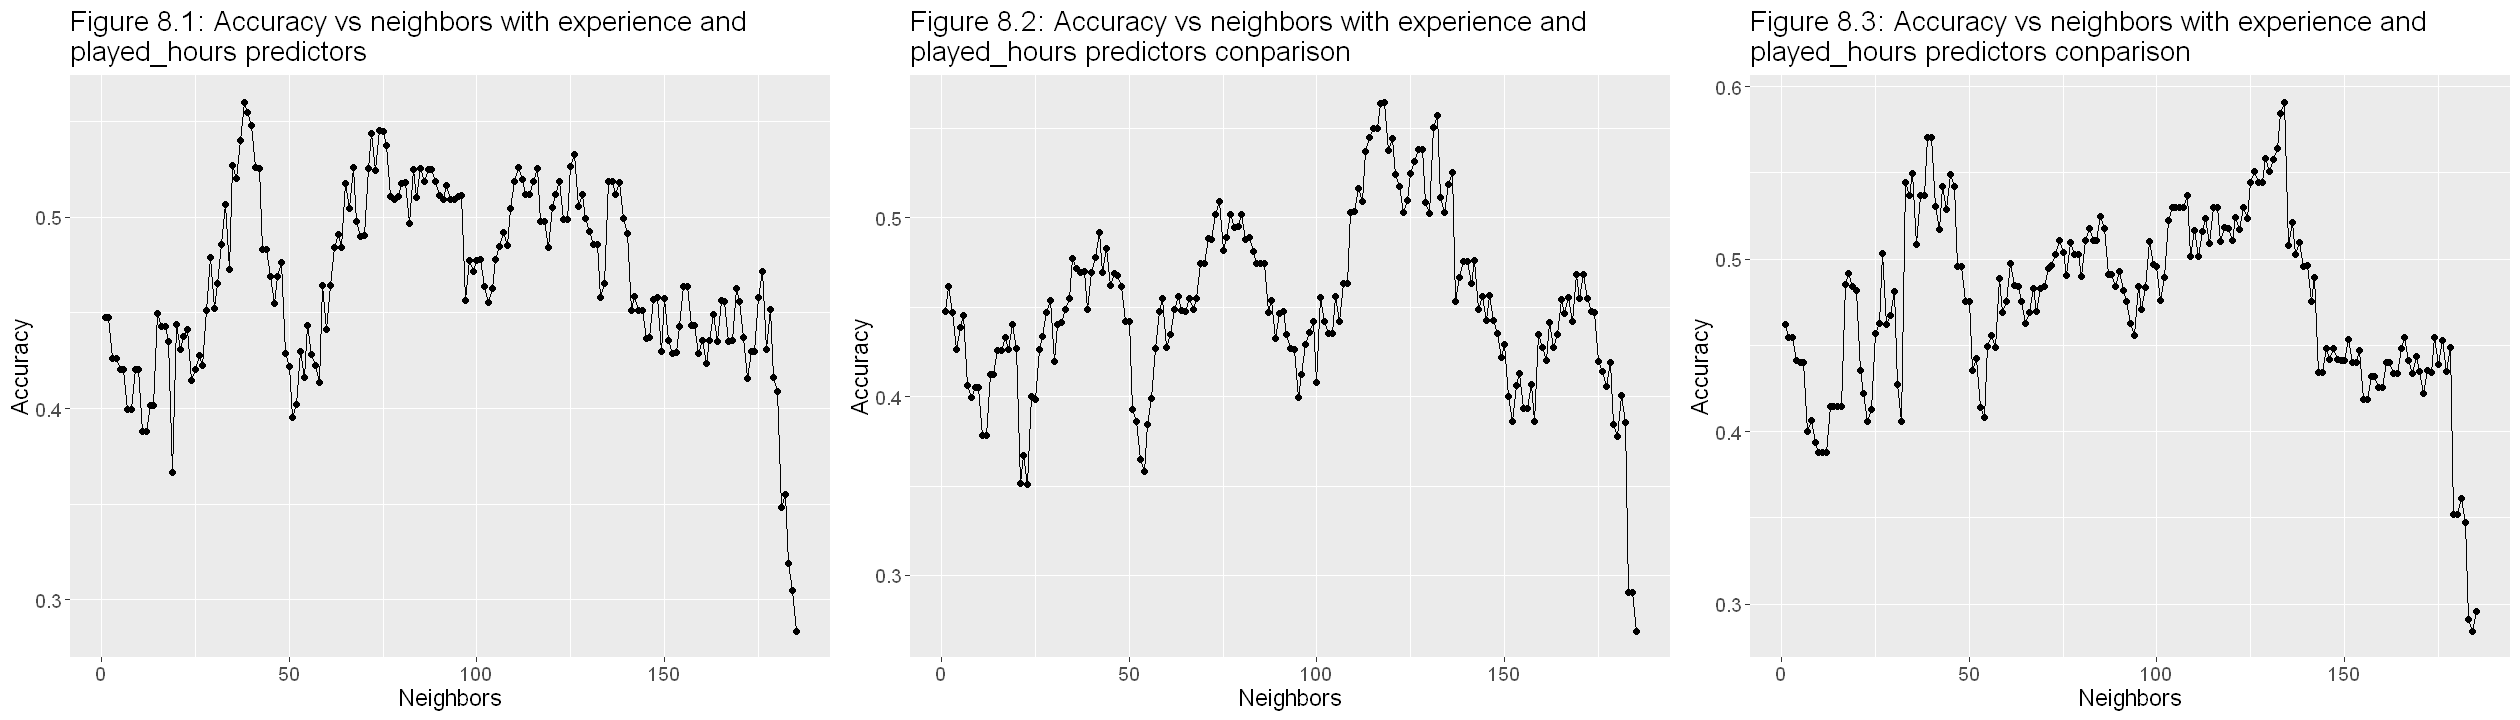

In [38]:
options(repr.plot.width = 21, repr.plot.height = 6)
plot_grid(exp_hrs_tuning_plot, exp_hrs_tuning_plot2, exp_hrs_tuning_plot3, ncol = 3)
slice(exp_hrs_metrics, 1)
slice(exp_hrs_metrics2, 1)
slice(exp_hrs_metrics3, 1)

`experience` and `played_hours` yielded accuracies from **56.0%-59.1%**. These are worse than the `age` predictor's accuracies; however, accuracies peak before all predictors are considered and thus are likely more reflective of actual predictions rather than a reflection of the majority label.

**(2.5.13)** Tuning `experience` and `age` predictor subset

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
185,accuracy,binary,0.7388278,10,0.01497049,Preprocessor1_Model185


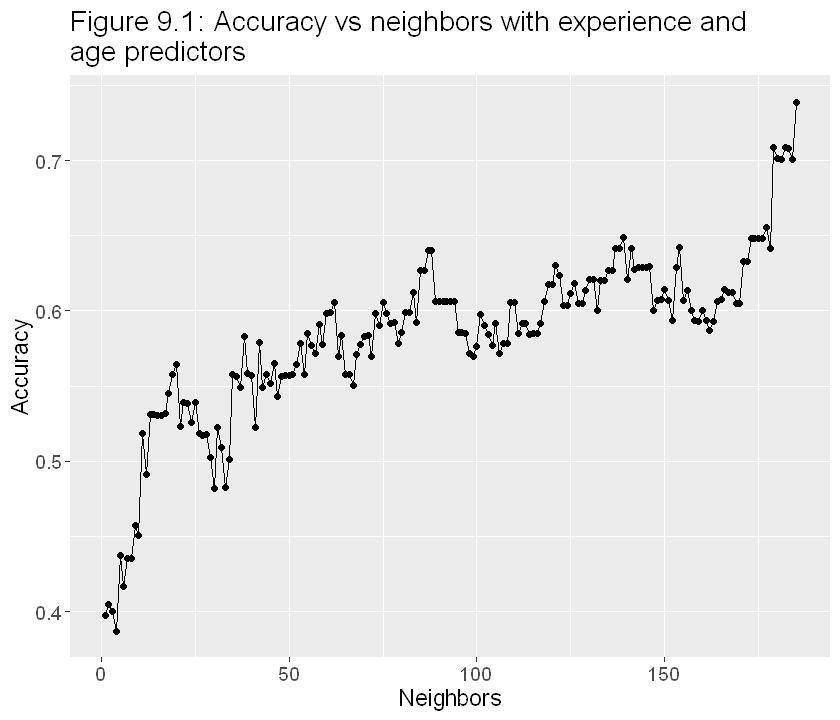

In [39]:
exp_age_metrics <- workflow() |>
    add_recipe(exp_age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

options(repr.plot.width = 7, repr.plot.height = 6)

exp_age_tuning_plot <- exp_age_metrics |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 9.1: Accuracy vs neighbors with experience and \nage predictors",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

exp_age_tuning_plot
slice(exp_age_metrics, 1)

Two addition vfolds:

In [40]:
exp_age_metrics2 <- workflow() |>
    add_recipe(exp_age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold2, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

exp_age_tuning_plot2 <- exp_age_metrics2 |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 9.2: Accuracy vs neighbors with experience and \nage predictors comparison",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


In [41]:
exp_age_metrics3 <- workflow() |>
    add_recipe(exp_age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold3, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

exp_age_tuning_plot3 <- exp_age_metrics3 |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 9.3: Accuracy vs neighbors with experience and \nage predictors comparison",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
185,accuracy,binary,0.7388278,10,0.01497049,Preprocessor1_Model185


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
185,accuracy,binary,0.6892308,10,0.0363574,Preprocessor1_Model185


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
185,accuracy,binary,0.6974725,10,0.02513356,Preprocessor1_Model185


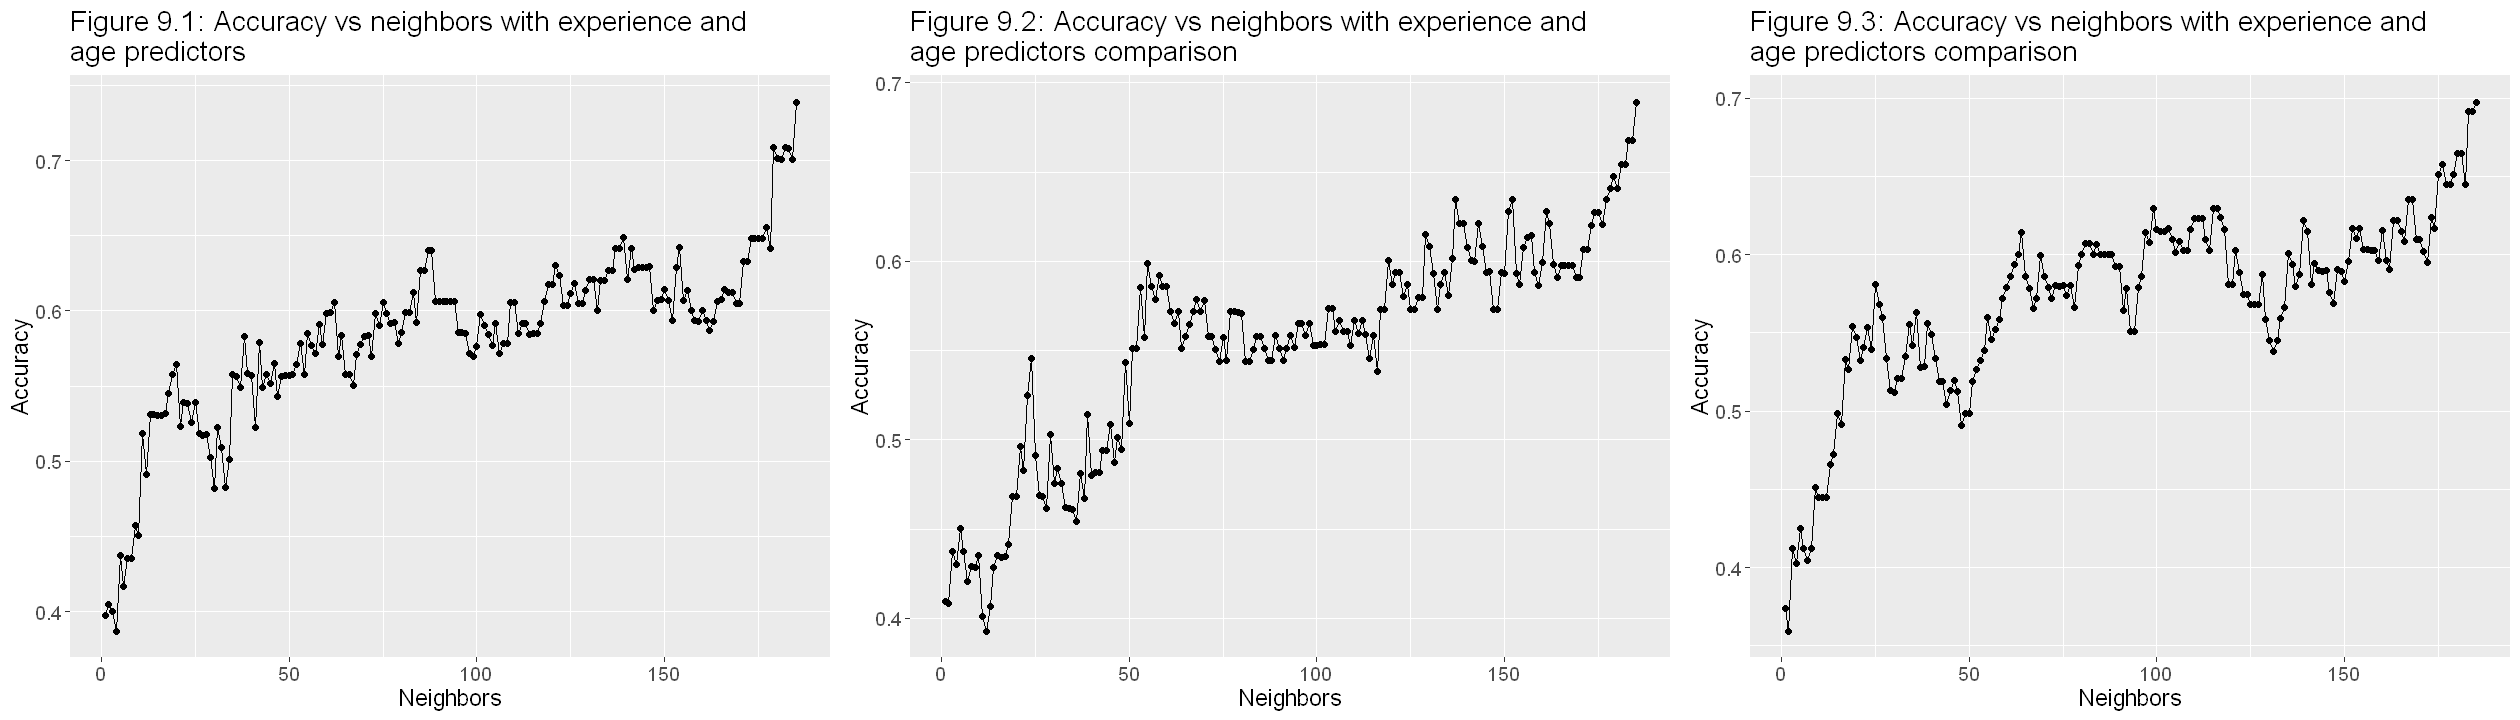

In [42]:
options(repr.plot.width = 21, repr.plot.height = 6)
plot_grid(exp_age_tuning_plot, exp_age_tuning_plot2, exp_age_tuning_plot3, ncol = 3)
slice(exp_age_metrics, 1)
slice(exp_age_metrics2, 1)
slice(exp_age_metrics3, 1)

`experience` and `age` produced peak accuracies from **68.9%-73.9%**. Whilst this initially seems great, these accuracies are only achieved when all neighbors are considered. That combined with the fact that the top accuracy of 73.9% is strikingly similar to the majority label fraction of 73.1% suggests that this model is also simply guessing the majority label for nearly every guess.

**(2.5.14)** Tuning `played_hours` and `age` predictor subset

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
135,accuracy,binary,0.5782051,10,0.0306557,Preprocessor1_Model135


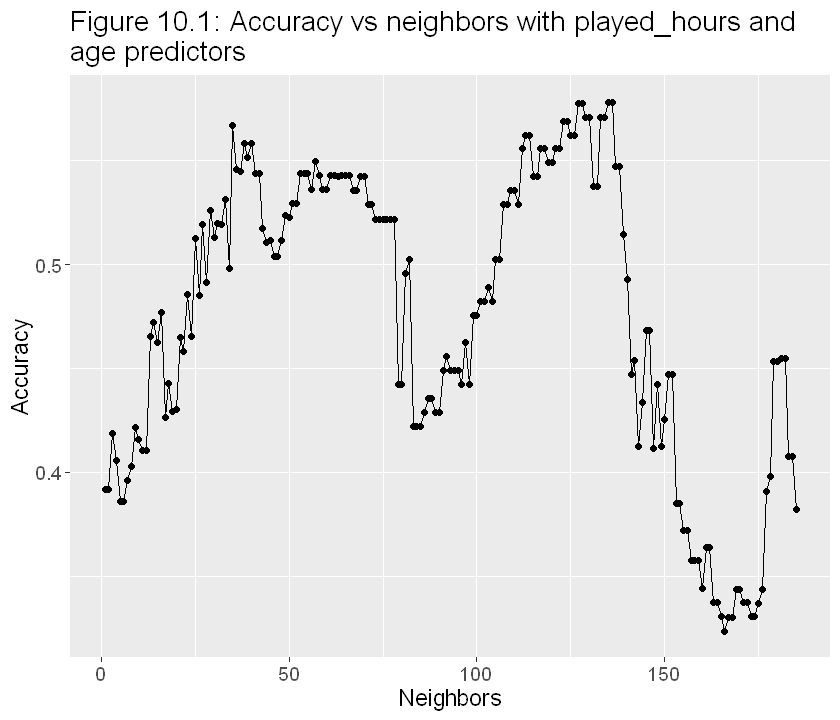

In [43]:
hrs_age_metrics <- workflow() |>
    add_recipe(hrs_age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

options(repr.plot.width = 7, repr.plot.height = 6)

hrs_age_tuning_plot <- hrs_age_metrics |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 10.1: Accuracy vs neighbors with played_hours and \nage predictors",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

hrs_age_tuning_plot
slice(hrs_age_metrics, 1)

Two additional vfolds:

In [44]:
hrs_age_metrics2 <- workflow() |>
    add_recipe(hrs_age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold2, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

hrs_age_tuning_plot2 <- hrs_age_metrics2 |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 10.2: Accuracy vs neighbors with played_hours and \nage predictors comparison",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


In [45]:
hrs_age_metrics3 <- workflow() |>
    add_recipe(hrs_age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold3, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

hrs_age_tuning_plot3 <- hrs_age_metrics3 |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 10.3: Accuracy vs neighbors with played_hours and \nage predictors comparison",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
135,accuracy,binary,0.5782051,10,0.0306557,Preprocessor1_Model135


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
39,accuracy,binary,0.5969597,10,0.05605444,Preprocessor1_Model039


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
57,accuracy,binary,0.596044,10,0.04783336,Preprocessor1_Model057


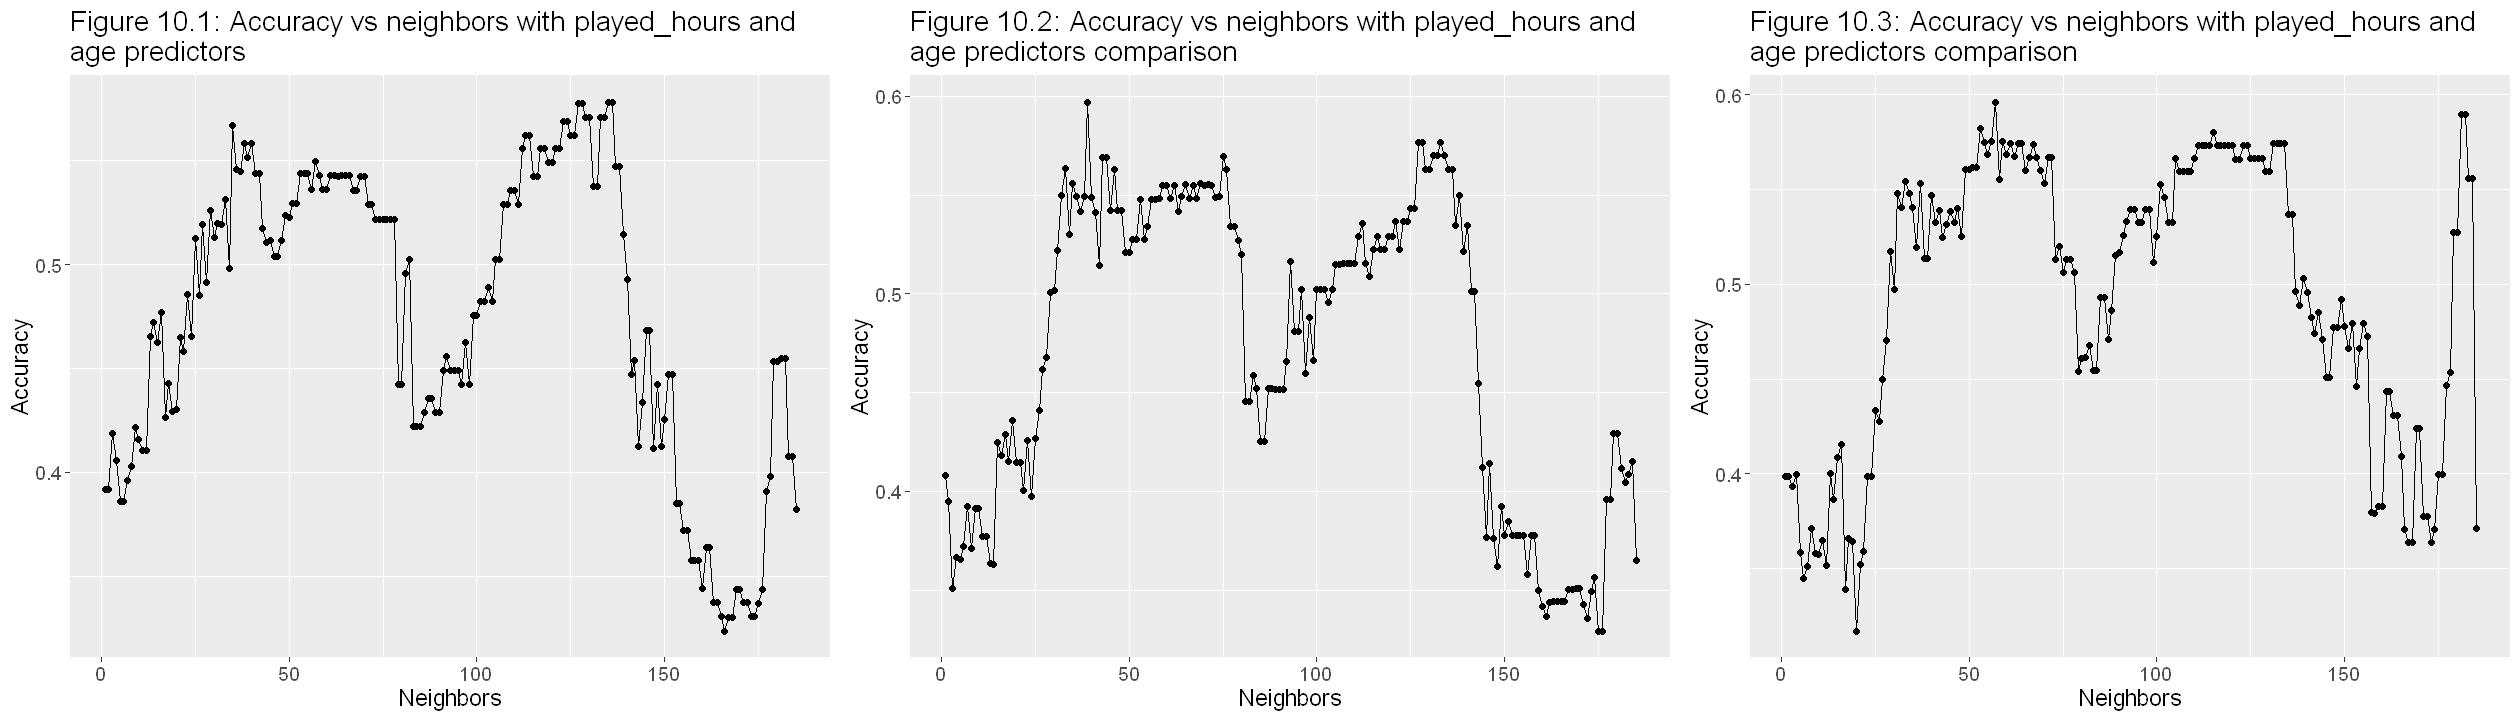

In [46]:
options(repr.plot.width = 21, repr.plot.height = 6)
plot_grid(hrs_age_tuning_plot, hrs_age_tuning_plot2, hrs_age_tuning_plot3, ncol = 3)
slice(hrs_age_metrics, 1)
slice(hrs_age_metrics2, 1)
slice(hrs_age_metrics3, 1)

`played_hours` and `age` produced peak accuracies of **57.8%-59.7%**. Whilst still worse than just guessing the majority label and also worse than some of the previous models, this model has the benefit of having its peak accuracy occur at a lower neighbor count. Particularly in Figure 10.2 and 10.3, the peaks occur at 39 and 57 neighbors repectively. This suggests that the model is capable of making real predictions instead of just guessing the majority label.

**(2.5.15)** Tuning `experiance`, `played_hours` and `age` predictor subset

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
39,accuracy,binary,0.5934432,10,0.02839664,Preprocessor1_Model039


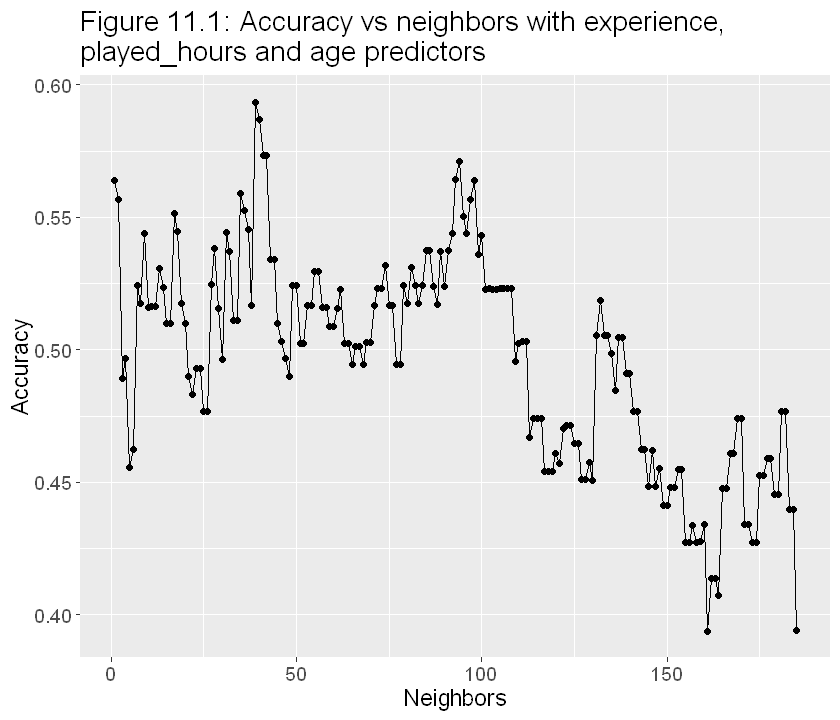

In [47]:
exp_hrs_age_metrics <- workflow() |>
    add_recipe(exp_hrs_age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

options(repr.plot.width = 7, repr.plot.height = 6)

exp_hrs_age_tuning_plot <- exp_hrs_age_metrics |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 11.1: Accuracy vs neighbors with experience, \nplayed_hours and age predictors",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

exp_hrs_age_tuning_plot
slice(exp_hrs_age_metrics, 1)

Two additional vfolds:

In [48]:
exp_hrs_age_metrics2 <- workflow() |>
    add_recipe(exp_hrs_age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold2, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

exp_hrs_age_tuning_plot2 <- exp_hrs_age_metrics2 |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 11.2: Accuracy vs neighbors with experience, \nplayed_hours and age predictors comparison",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


In [49]:
exp_hrs_age_metrics3 <- workflow() |>
    add_recipe(exp_hrs_age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold3, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

exp_hrs_age_tuning_plot3 <- exp_hrs_age_metrics3 |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Figure 11.3: Accuracy vs neighbors with experience, \nplayed_hours and age predictors comparison",
         x = "Neighbors",
         y = "Accuracy") +
    theme(text = element_text(size = 14))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
39,accuracy,binary,0.5934432,10,0.02839664,Preprocessor1_Model039


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5662271,10,0.0252276,Preprocessor1_Model001


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
18,accuracy,binary,0.5889011,10,0.03669644,Preprocessor1_Model018


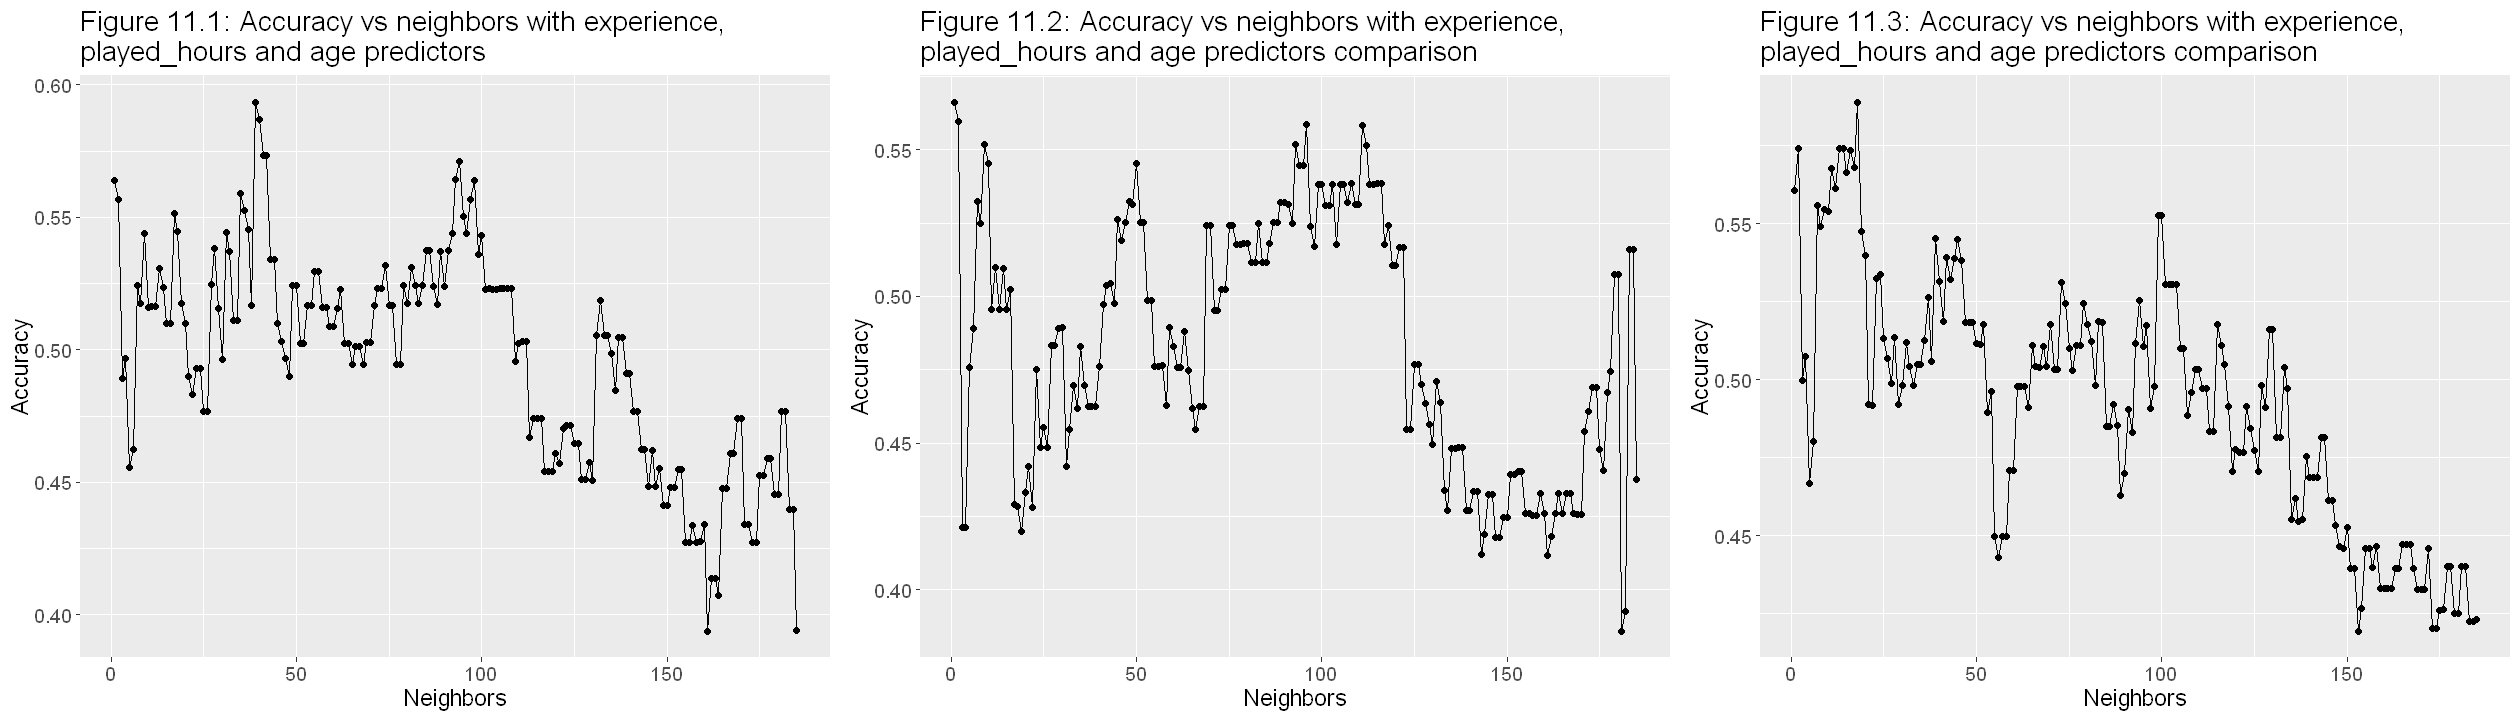

In [50]:
options(repr.plot.width = 21, repr.plot.height = 6)
plot_grid(exp_hrs_age_tuning_plot, exp_hrs_age_tuning_plot2, exp_hrs_age_tuning_plot3, ncol = 3)
slice(exp_hrs_age_metrics, 1)
slice(exp_hrs_age_metrics2, 1)
slice(exp_hrs_age_metrics3, 1)

`experience`, `played_hours` and  `age` produced peak accuracies of **56.6%-59.3%**. There are highly comporable results to those of `played_hours` and `age`. Furthermore, the consistently low peak neighbour count also suggests that real nuanced predictions are being made. Whilst still having a lower accuracy than just guessing the majority label, this subset is promising.

**(2.5.16)** Subset comparison

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`)."


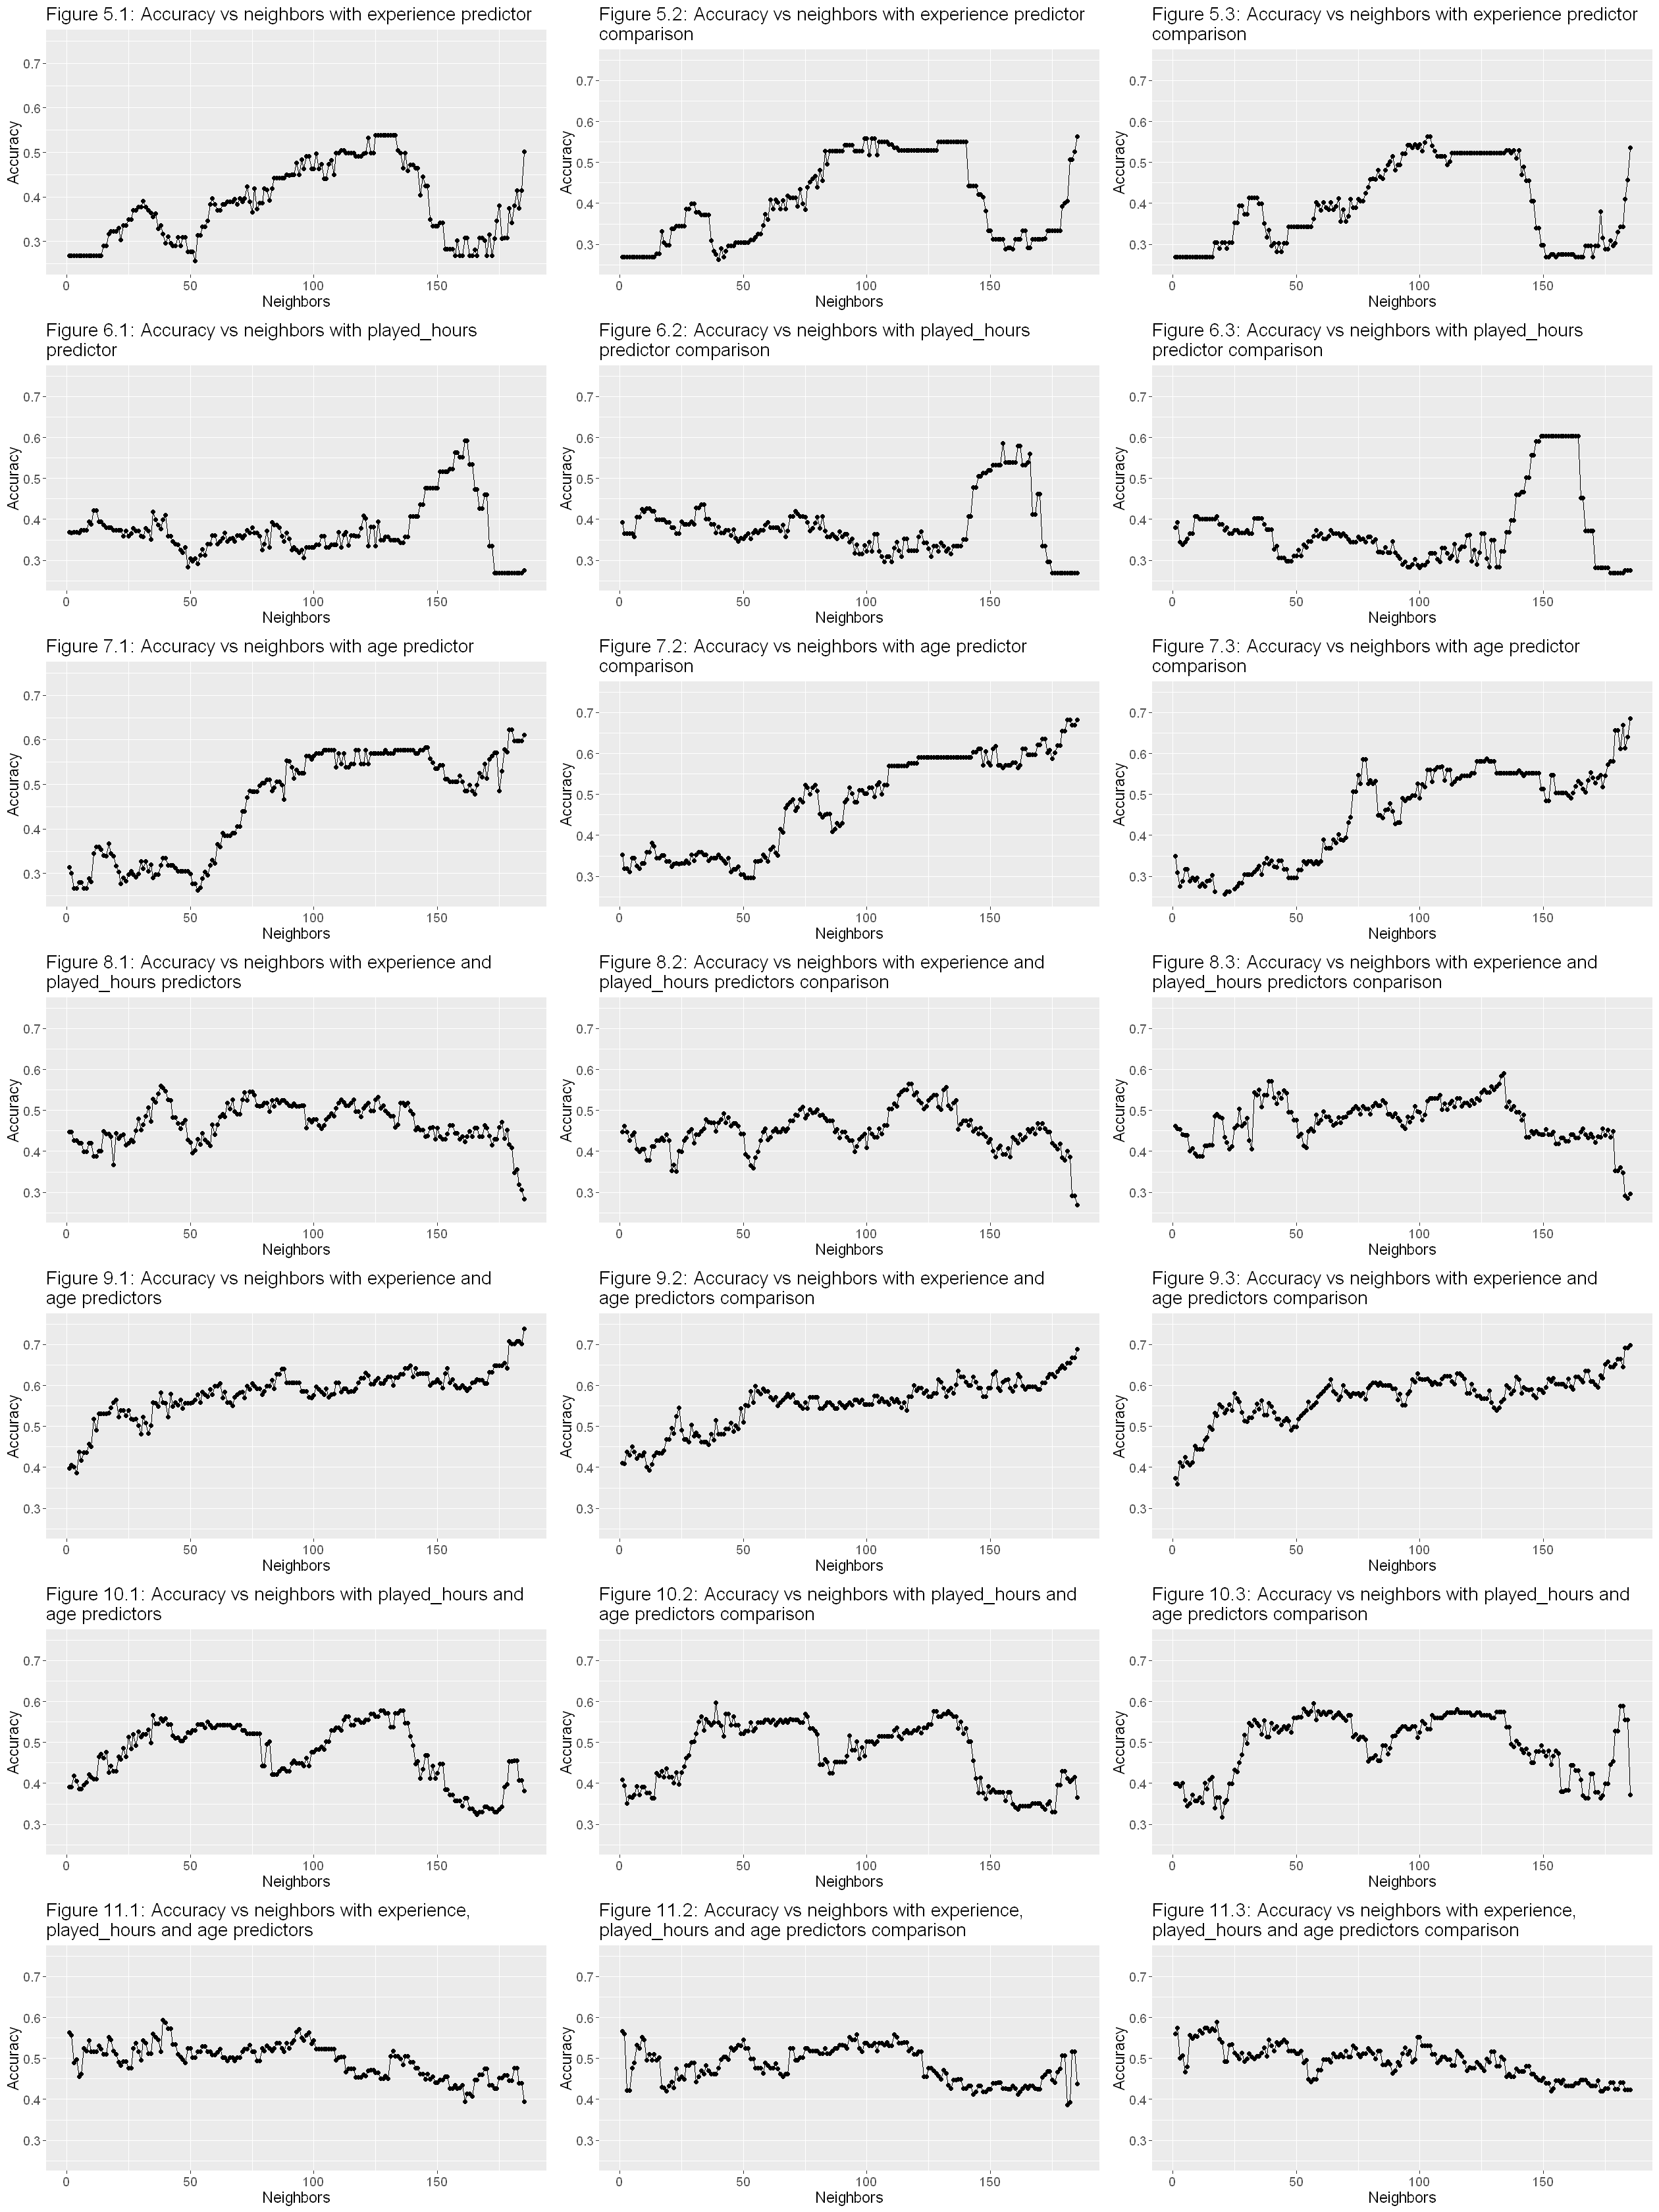

In [51]:
options(repr.plot.width = 21, repr.plot.height = 28)

exp_tuning_plot_scaled <- exp_tuning_plot + ylim(c(0.25, 0.75))
exp_tuning_plot2_scaled <- exp_tuning_plot2 + ylim(c(0.25, 0.75))
exp_tuning_plot3_scaled <- exp_tuning_plot3 + ylim(c(0.25, 0.75))

hrs_tuning_plot_scaled <- hrs_tuning_plot + ylim(c(0.25, 0.75))
hrs_tuning_plot2_scaled <- hrs_tuning_plot2 + ylim(c(0.25, 0.75))
hrs_tuning_plot3_scaled <- hrs_tuning_plot3 + ylim(c(0.25, 0.75))

age_tuning_plot_scaled <- age_tuning_plot + ylim(c(0.25, 0.75))
age_tuning_plot2_scaled <- age_tuning_plot2 + ylim(c(0.25, 0.75))
age_tuning_plot3_scaled <- age_tuning_plot3 + ylim(c(0.25, 0.75))

exp_hrs_tuning_plot_scaled <- exp_hrs_tuning_plot + ylim(c(0.25, 0.75))
exp_hrs_tuning_plot2_scaled <- exp_hrs_tuning_plot2 + ylim(c(0.25, 0.75))
exp_hrs_tuning_plot3_scaled <- exp_hrs_tuning_plot3 + ylim(c(0.25, 0.75))

exp_age_tuning_plot_scaled <- exp_age_tuning_plot + ylim(c(0.25, 0.75))
exp_age_tuning_plot2_scaled <- exp_age_tuning_plot2 + ylim(c(0.25, 0.75))
exp_age_tuning_plot3_scaled <- exp_age_tuning_plot3 + ylim(c(0.25, 0.75))

hrs_age_tuning_plot_scaled <- hrs_age_tuning_plot + ylim(c(0.25, 0.75))
hrs_age_tuning_plot2_scaled <- hrs_age_tuning_plot2 + ylim(c(0.25, 0.75))
hrs_age_tuning_plot3_scaled <- hrs_age_tuning_plot3 + ylim(c(0.25, 0.75))

exp_hrs_age_tuning_plot_scaled <- exp_hrs_age_tuning_plot + ylim(c(0.25, 0.75))
exp_hrs_age_tuning_plot2_scaled <- exp_hrs_age_tuning_plot2 + ylim(c(0.25, 0.75))
exp_hrs_age_tuning_plot3_scaled <- exp_hrs_age_tuning_plot3 + ylim(c(0.25, 0.75))

plot_grid(exp_tuning_plot_scaled, exp_tuning_plot2_scaled, exp_tuning_plot3_scaled,
          hrs_tuning_plot_scaled, hrs_tuning_plot2_scaled, hrs_tuning_plot3_scaled,
          age_tuning_plot_scaled, age_tuning_plot2_scaled, age_tuning_plot3_scaled,
          exp_hrs_tuning_plot_scaled, exp_hrs_tuning_plot2_scaled, exp_hrs_tuning_plot3_scaled,
          exp_age_tuning_plot_scaled, exp_age_tuning_plot2_scaled, exp_age_tuning_plot3_scaled,
          hrs_age_tuning_plot_scaled, hrs_age_tuning_plot2_scaled, hrs_age_tuning_plot3_scaled,
          exp_hrs_age_tuning_plot_scaled, exp_hrs_age_tuning_plot2_scaled, exp_hrs_age_tuning_plot3_scaled,
          ncol = 3)


To select potentially useful subsets from this selection, subsets with generally low accuracy or accuracy that is only good when the majority of avaliable neighbors will be elimitated. This criteria will allow the highest accuracy to be achived while also perserving nuance in prediction by not underfitting the data. Figures 5, 6, 7 and 8 suffer from generally low accuracy. Figure 9 suffers from the peak being at the maximum neighbor count suggesting severe underfitting. This leave Figures 10 and 11 as the only promising candidates for nuanced prediction with decent accuracy. However, Figure 11 is has a more consistent peak; 39, 57 and 135 for Figure 10 vs 1, 18 and 39 for Figure 11. This leaves us with our best subset:`experience` + `played_hours` + `age`.

**(2.5.17)** Selecting K for best subset: `played_hours` + `age`

Given that the neighbor count at the peak accuracies for Figures 11.1, 11.2 and 11.3 stil vary significantly, 5 20-fold validations will be used to determine the absolute best value for k.

In [52]:
set.seed(1000)
players_vfold20_1 <- vfold_cv(players_training, v = 20, strata = subscribe)

In [53]:
set.seed(2000)
players_vfold20_2 <- vfold_cv(players_training, v = 20, strata = subscribe)

In [54]:
set.seed(3000)
players_vfold20_3 <- vfold_cv(players_training, v = 20, strata = subscribe)

In [55]:
set.seed(4000)
players_vfold20_4 <- vfold_cv(players_training, v = 20, strata = subscribe)

In [56]:
set.seed(5000)
players_vfold20_5 <- vfold_cv(players_training, v = 20, strata = subscribe)

In [68]:
exp_hrs_age_metrics_final_1 <- workflow() |>
    add_recipe(exp_hrs_age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold20_1, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


In [69]:
exp_hrs_age_metrics_final_2 <- workflow() |>
    add_recipe(exp_hrs_age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold20_2, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


In [70]:
exp_hrs_age_metrics_final_3 <- workflow() |>
    add_recipe(exp_hrs_age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold20_3, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


In [71]:
exp_hrs_age_metrics_final_4 <- workflow() |>
    add_recipe(exp_hrs_age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold20_4, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


In [72]:
exp_hrs_age_metrics_final_5 <- workflow() |>
    add_recipe(exp_hrs_age_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold20_5, grid = neighbors) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

Warning message:
"! tune detected a parallel backend registered with foreach but no backend
  registered with future.
ℹ Support for parallel processing with foreach was soft-deprecated in tune
  1.2.1.
ℹ See ?parallelism (`?tune::parallelism()`) to learn more."


In [79]:
slice(exp_hrs_age_metrics_final_1, 1:4)
slice(exp_hrs_age_metrics_final_2, 1:4)
slice(exp_hrs_age_metrics_final_3, 1:4)
slice(exp_hrs_age_metrics_final_4, 1:4)
slice(exp_hrs_age_metrics_final_5, 1:4)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
18,accuracy,binary,0.6080357,20,0.03607606,Preprocessor1_Model018
17,accuracy,binary,0.6068452,20,0.03725648,Preprocessor1_Model017
39,accuracy,binary,0.5979167,20,0.04220577,Preprocessor1_Model039
40,accuracy,binary,0.5937500,20,0.03702653,Preprocessor1_Model040


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
105,accuracy,binary,0.5705357,20,0.03579584,Preprocessor1_Model105
108,accuracy,binary,0.5705357,20,0.03426268,Preprocessor1_Model108
13,accuracy,binary,0.5702381,20,0.04245275,Preprocessor1_Model013
17,accuracy,binary,0.5660714,20,0.04651344,Preprocessor1_Model017


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,accuracy,binary,0.5687500,20,0.03077376,Preprocessor1_Model013
17,accuracy,binary,0.5681548,20,0.04085194,Preprocessor1_Model017
105,accuracy,binary,0.5627976,20,0.03997990,Preprocessor1_Model105
106,accuracy,binary,0.5627976,20,0.03997990,Preprocessor1_Model106


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
17,accuracy,binary,0.6062500,20,0.04031618,Preprocessor1_Model017
18,accuracy,binary,0.5866071,20,0.04301106,Preprocessor1_Model018
21,accuracy,binary,0.5741071,20,0.04746308,Preprocessor1_Model021
11,accuracy,binary,0.5726190,20,0.04312607,Preprocessor1_Model011


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,accuracy,binary,0.5627976,20,0.03676523,Preprocessor1_Model013
26,accuracy,binary,0.5583333,20,0.03736425,Preprocessor1_Model026
14,accuracy,binary,0.5565476,20,0.03560316,Preprocessor1_Model014
12,accuracy,binary,0.5556548,20,0.03519165,Preprocessor1_Model012


From the above ideal neighbors, 17 appears the most often showing up in 4 of the 5 vfold's top 4 neighbor counts. Hence, $K=17$ will be chosen.

**(2.5.18)** Creation of final model

Model specification:

In [80]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
    set_engine("kknn") |>
    set_mode("classification")

Fitting data to recipe and final model:

In [81]:
players_fit <- workflow() |>
    add_recipe(exp_hrs_age_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_training)

**(2.5.19)** Model evaluation with test data set

In [84]:
players_predictions <- players_fit |>
    predict(players_testing) |>
    bind_cols(players_testing) 

players_predictions_accuracy <- players_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

players_predictions_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6122449


In [59]:
# Stoppes parallel processing:
# stopCluster(cl)

## (3) Discussion

From the data, it was found that 73.1% of players were subscribed whilst 26.8% were not. The predictors `experience`, `played_hours` and `age` were put through best-subset-selection with KNN-Classification and 3 10-fold cross-validations each. From this, it was found that no subset had a particularly high accuracy with all subsets exhibiting quite an erratic trend in accuracy as the number of neighbors changed. All together, this general lack of accuracy and consistency suggest that none of `experience`, `played_hours` or `age` are highly predictive of subscription. However, out of the subsets tested, the subset that included all three predictors was able to make the most accurate nuanced predictions without befalling to underfitting. The subset was then put through 5 round of 20-fold cross-validation in KNN-Classification to find the optimal value for K. $K=17$ was chosen and used to create the final model. Through accuracy evaluation with the testing set, an accuracy of **61.2%** was yielded.

Based on exploratory data analyses, this result is not too surprising. It was seen during early data exploration that there correlations between predictors and the label were quite weak and inconsistent but still present. As such, the yielded accuracy of 61.2% is mildly better than random guessing (which would yield ~50%).

However, the accuracy still remains below the proportion of the majority label (73.1%). Indicating that the data-analysis performed was unable to produce a truly useful prediction model for subscription. This implictes that for the developers of PLAICRAFT, subscription prediction with `experience`, `played_hours` and `age` is largely futile as it would be more accurate just to assume that everyone subscribes. 

Future questions that the developers of PLAICRAFT could ask to further their understanding of player subscriptions are:
- Will a greater dataset with more observations and variables be sufficiently predictive of subscription to beat the proportion of the majority label?
- Will a different classification model other than KNN provide a greater predictive accuracy?

## (4) References
Pacific Laboratory of Artificial Intelligence. (2024). PLAICraft. Plaicraft.ai. https://plaicraft.ai/